# TP2 - Redes Neuronales (22.45)

En este trabajo páctico se busca armar una red neuronal CONVOLUCIONAL capaz de obtener el mayor acuracy para lograr la mejor posición en la competencia de Kaggle. Se utiliza el dataset "cifar-100" y todos los conocimientos vistos en clase para la realización de la red capaz de identificar las fotos dentro del dataset.

*Autor: Nicolás Bustelo - 61431*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils import plot_model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_fine.npy
/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_coarse.npy
/kaggle/input/itba-rn-2245-cifar-100-2023q2/fine_label_names.pck
/kaggle/input/itba-rn-2245-cifar-100-2023q2/coarse_label_names.pck
/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_test.npy
/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_train.npy


## Dataset load

In [2]:
x_train = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-rn-2245-cifar-100-2023q2/y_train_fine.npy")

In [3]:
import pickle
with open("/kaggle/input/itba-rn-2245-cifar-100-2023q2/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-rn-2245-cifar-100-2023q2/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [4]:
from matplotlib import pyplot as plt

## Dataset sample viewing
En esta sección se analizan los datos, su tamaño y sus caracteristicas

In [5]:
# Tenemos que clasificar entre 100 clases
print("Grano grueso:", len(labels_coarse))
print("Grano fino:", len(labels_fine))

Grano grueso: 20
Grano fino: 100


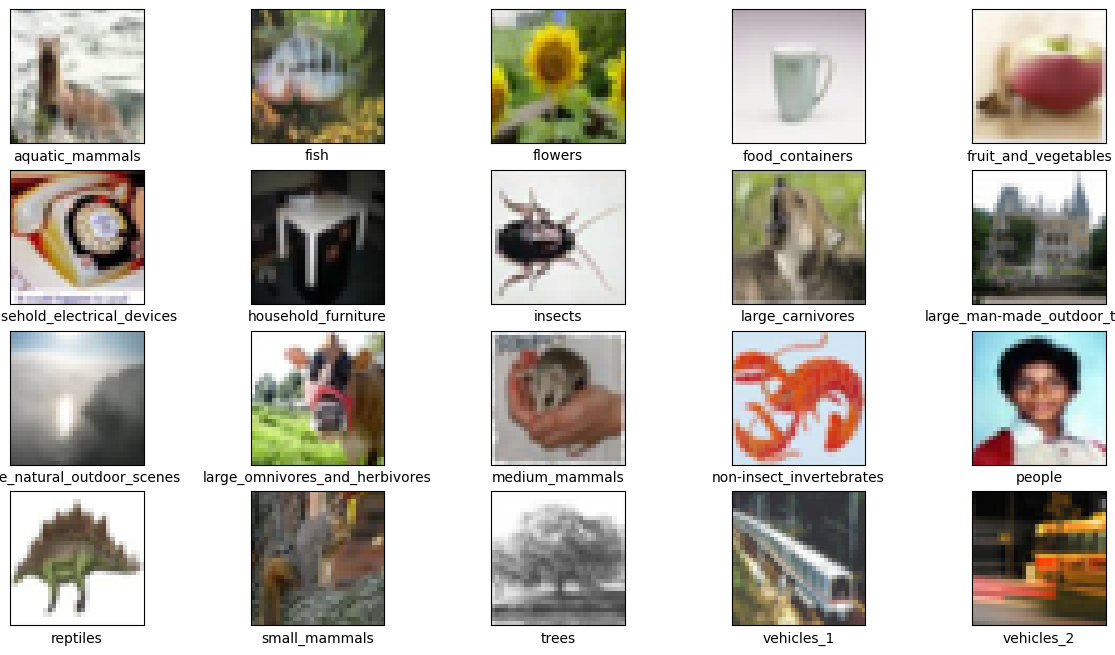

In [6]:
# Imprimimos una foto de cada grano grueso
plt.figure(figsize=(15,8))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[y_train_coarse==i][0])
    plt.xlabel(labels_coarse[i])
plt.show()

Text(0.5, 1.0, 'large_omnivores_and_herbivores')

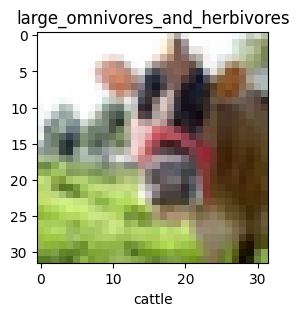

In [7]:
# Una imagen
plt.figure(figsize=(3,3))
plt.imshow(x_train[y_train_coarse==11][0])
plt.xlabel(labels_fine[y_train_fine[0]])
plt.title(labels_coarse[11])

In [8]:
# Me fijo para la categoría anterior, cuáles son las categorías de grano fino
coarse = 11
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: large_omnivores_and_herbivores
Grano fino: camel
Grano fino: cattle
Grano fino: chimpanzee
Grano fino: elephant
Grano fino: kangaroo


In [9]:
# Hay una misma cantidad de datos de cada clase fina, podriamos confirmar una distribución uniforme
#count=[np.count_nonzero(y_train_fine==value) for value in range(100)]
#plt.bar(range(100), count)
#plt.xlabel('Train fine classes')
#plt.title('Train Composition')

### Data convert to GreyScale: 
grayImages es el vector con todas las imagenes en escala de grises. Se probó la red con las imagenes en escala de grises y se obtuvo un peor rendimiendo que a color.

51200000

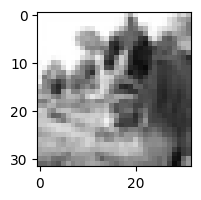

In [10]:
grayImages = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])
plt.figure(figsize=(2,2))
plt.imshow(grayImages[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
grayImages.size

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
 x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_fine, test_size=0.2, random_state=42, stratify=y_train_fine)

## Data Augmentation with flip image

Demostró aumentar significativamente el accuracy 

In [13]:
aux = np.flip(x_train, axis=2)
x_train_aug2 = np.concatenate((x_train, aux))
y_train_fine_aug2 = np.concatenate((y_train, y_train))

In [14]:
# Se intento aumentar más los datos y no resultó en un mejor accuracy
aux2 = np.flip(x_train_aug2, axis=1)
x_train_aug4 = np.concatenate((x_train_aug2, aux2))
y_train_fine_aug4 = np.concatenate((y_train_fine_aug2, y_train_fine_aug2))

## Model Training:

In [15]:
# Importo las bibliotecas a utilizar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

import keras
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers.core import Dense, Flatten, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D, Input,Add

**Red utilizada**

Primero se utilizó una flatten de entrada. Luego como hidden layers se utilizó una combinación entre capas con activación Relu y capas con activación Sigmoide ya que eran las que mejores resultados arrojaba. 
En la capa de salida se utilizo la Softmax.

Una mejora importante se dió con el uso del kernel Constraint!

In [16]:
'''
model = Sequential()
#model.add(Flatten(input_shape=(32,32))) #B&W IMAGES
model.add(Flatten(input_shape=(32,32,3))) #COLOR IMAGES
model.add(Dense(1024, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='sigmoid', kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='sigmoid', kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))
'''

'\nmodel = Sequential()\n#model.add(Flatten(input_shape=(32,32))) #B&W IMAGES\nmodel.add(Flatten(input_shape=(32,32,3))) #COLOR IMAGES\nmodel.add(Dense(1024, activation=\'relu\', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))\nmodel.add(Dropout(0.1))\nmodel.add(Dense(512, activation=\'sigmoid\', kernel_constraint=MaxNorm(5)))\nmodel.add(Dropout(0.1))\nmodel.add(Dense(1024, activation=\'relu\', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))\nmodel.add(Dropout(0.1))\nmodel.add(Dense(512, activation=\'sigmoid\', kernel_constraint=MaxNorm(5)))\nmodel.add(Dropout(0.1))\nmodel.add(Dense(100, activation="softmax"))\nmodel.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))\n'

In [17]:
# Tipo Inception
'''
net_input = Input(shape=(32,32,3))

def inception_block(input_layer,filters=64):
    tower_1 = Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer)
    tower_1 = Conv2D(filters, (3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer)
    tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    tower_3 = Conv2D(filters, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    return output


net=inception_block(net_input,filters=4)
net=inception_block(net,filters=4)
net=inception_block(net,filters=4)
net=inception_block(net,filters=4)
net=inception_block(net,filters=4)
net=inception_block(net,filters=4)

net=Flatten()(net)

net=Dense(units=128, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.1)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(net_input,net)

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = 'Adam')

model.summary()
'''

'\nnet_input = Input(shape=(32,32,3))\n\ndef inception_block(input_layer,filters=64):\n    tower_1 = Conv2D(filters, (1,1), padding=\'same\', activation=\'relu\')(input_layer)\n    tower_1 = Conv2D(filters, (3,3), padding=\'same\', activation=\'relu\')(tower_1)\n    tower_2 = Conv2D(filters, (1,1), padding=\'same\', activation=\'relu\')(input_layer)\n    tower_2 = Conv2D(64, (5,5), padding=\'same\', activation=\'relu\')(tower_2)\n    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding=\'same\')(input_layer)\n    tower_3 = Conv2D(filters, (1,1), padding=\'same\', activation=\'relu\')(tower_3)\n    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)\n    return output\n\n\nnet=inception_block(net_input,filters=4)\nnet=inception_block(net,filters=4)\nnet=inception_block(net,filters=4)\nnet=inception_block(net,filters=4)\nnet=inception_block(net,filters=4)\nnet=inception_block(net,filters=4)\n\nnet=Flatten()(net)\n\nnet=Dense(units=128, activation=\'relu\')(net)\nnet=

In [18]:
# Tipo ResNET
net_input = Input(shape=(32,32,3))

def res_block_first(input_layer,filters=16):
    
    #Primera capa
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(aux_net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    
    #Shortcut
    net=Add()([aux_net,net])
    
    net=Activation("relu")(net)
    net=MaxPooling2D()(net)
    
    return net

def res_block(input_layer,filters=16):
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    
    #Shortcut
    net=Add()([input_layer,net])
    net=Activation("relu")(net)
    
    return net

def res_block_dec(input_layer,filters=32):
    
    input_layer=MaxPooling2D()(input_layer)
    net=Conv2D(filters=filters, kernel_size=(1, 1), padding='same')(input_layer)
    aux_net=BatchNormalization()(net)
    
    #conexión directa
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_layer)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Activation("relu")(net)
    
    net=Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(net)
    net=BatchNormalization()(net)
    net=Add()([aux_net,net])
    net=Activation("relu")(net)
    
    return net

net=res_block_first(net_input,filters=32)
net=res_block(net,filters=32)
net=res_block(net,filters=32)
net=res_block(net,filters=32)

net=res_block_dec(net,filters=64)
net=res_block(net,filters=64)
net=res_block(net,filters=64)
net=res_block(net,filters=64)

net=res_block_dec(net,filters=128)
net=res_block(net,filters=128)
net=res_block(net,filters=128)
net=res_block(net,filters=128)

net = AveragePooling2D()(net)

net=Flatten()(net)

net=Dense(units=1000, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(net_input,net)

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

In [19]:
# Tipo VGG
'''
model = Sequential()

model.add(Conv2D(filters=20, kernel_size=(3, 3), input_shape=(32,32,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(5)))
model.add(Dropout(0.1))

model.add(Dense(units=100, activation = 'softmax'))

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))
'''

'\nmodel = Sequential()\n\nmodel.add(Conv2D(filters=20, kernel_size=(3, 3), input_shape=(32,32,3), padding=\'same\'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(filters=32, kernel_size=(3, 3), padding=\'same\'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(filters=64, kernel_size=(3, 3), padding=\'same\'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\nmodel.add(MaxPooling2D())\n\nmodel.add(Conv2D(filters=128, kernel_size=(3, 3), padding=\'same\'))\nmodel.add(BatchNormalization())\nmodel.add(Activation(\'relu\'))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(1024, activation=\'relu\', kernel_initializer=initializers.RandomNormal(stddev=0.1), kernel_constraint=MaxNorm(5)))\nmodel.add(Dropout(0.1))\nmodel.add(Dense(512, activation=\'relu\', kernel_constraint=MaxNorm(5)))\nmodel.add(Dropout(0.1))\n\nmodel.add(Dense(units=100, activation

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['batch_normalization[0][0]']

In [21]:
# Descomentar para visualidar las capas de la red
#plot_model(model,show_shapes=True,show_layer_names=True)

### Callbacks:

In [22]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [23]:
mc = ModelCheckpoint(
    "best_weights.hfd5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [24]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 6, 
    verbose = 1,
    restore_best_weights = True,
)

In [25]:
tb = TensorBoard(
    log_dir="logs",
)

### Entreno el modelo:

In [26]:
history = model.fit(
    x = x_train_aug2, 
    y = y_train_fine_aug2, 
    batch_size=64, 
    epochs=200, 
    validation_data = (x_val, y_val), 
    callbacks= [
        rlrop,
        es,
        mc,
        tb,
    ]
)

Epoch 1/200
1248/1250 [============================>.] - ETA: 0s - loss: 3.6191 - accuracy: 0.1404
Epoch 1: val_accuracy improved from -inf to 0.21340, saving model to best_weights.hfd5
1250/1250 [==============================] - 65s 26ms/step - loss: 3.6180 - accuracy: 0.1406 - val_loss: 3.5019 - val_accuracy: 0.2134 - lr: 0.0010
Epoch 2/200
1250/1250 [==============================] - ETA: 0s - loss: 2.6217 - accuracy: 0.3165
Epoch 2: val_accuracy improved from 0.21340 to 0.32350, saving model to best_weights.hfd5
1250/1250 [==============================] - 31s 25ms/step - loss: 2.6217 - accuracy: 0.3165 - val_loss: 2.5858 - val_accuracy: 0.3235 - lr: 0.0010
Epoch 3/200
1248/1250 [============================>.] - ETA: 0s - loss: 2.0974 - accuracy: 0.4280
Epoch 3: val_accuracy improved from 0.32350 to 0.37510, saving model to best_weights.hfd5
1250/1250 [==============================] - 31s 24ms/step - loss: 2.0971 - accuracy: 0.4281 - val_loss: 2.4206 - val_accuracy: 0.3751 - lr:

## Results

Se probaron diferentes modelos y el mejor resultado se muestra a continuación.

In [27]:
last_valacc = history.history['val_accuracy'][-1]*100
print("Last Validation Accuracy:" , format(last_valacc, ".2f"), "%")
last_acc = history.history['accuracy'][-1]*100
print("Last Accuracy:" , format(last_acc, ".2f"), "%")

Last Validation Accuracy: 59.59 %
Last Accuracy: 99.94 %


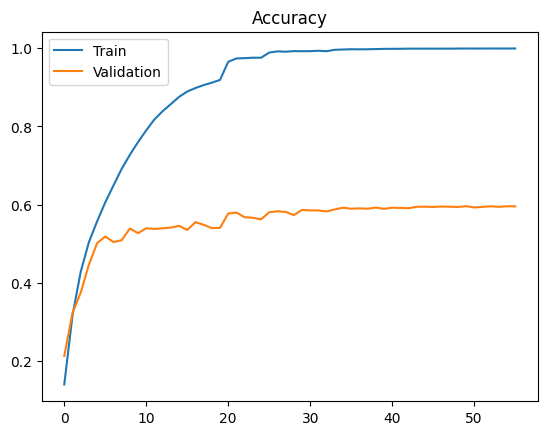

In [28]:
plt.plot(history.history["accuracy"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.title("Accuracy")
plt.legend()

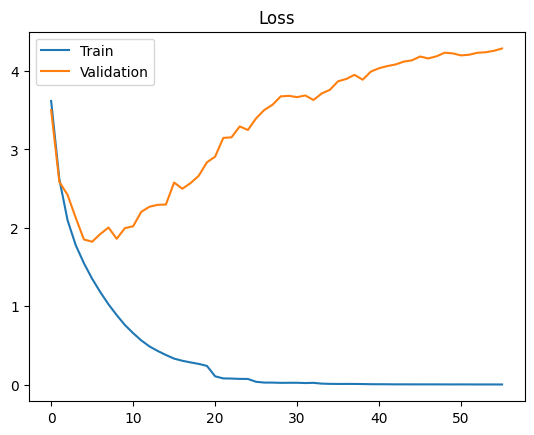

In [29]:
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_loss"], label='Validation')
plt.title("Loss")
plt.legend()

## Submissions generator



In [30]:
predictions = model.predict(x_test).argmax(axis=1)

313/313 [==============================] - 2s 5ms/step


In [31]:
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"
df.to_csv("submission.csv")

En conclusión, el uso de la red arrojo un accuracy significativo para tener 100 clases a clasificar, se aprendió en el proceso el uso de MLP, normalizadores, tipos de capas y diferentes maneras de modificar parámetros para obtener el mejor resultado posible. 